                   High          Low  ...     Volume    Adj Close
Date                                  ...                        
2006-01-02    71.995003    70.699997  ...  2685520.0    43.341618
2006-01-03    71.800003    68.000000  ...  1282790.0    43.332512
2006-01-04    73.504997    71.400002  ...  5369920.0    44.471554
2006-01-05    74.300003    72.525002  ...  3853500.0    44.924141
2006-01-06    77.500000    73.000000  ...  8616860.0    46.713196
...                 ...          ...  ...        ...          ...
2020-09-21  1071.349976  1041.500000  ...  9921439.0  1049.300049
2020-09-22  1058.150024  1029.500000  ...  9310339.0  1035.400024
2020-09-23  1055.000000  1034.349976  ...  8039914.0  1047.250000
2020-09-24  1047.000000  1025.000000  ...  9904755.0  1030.400024
2020-09-25  1050.000000  1025.650024  ...  6975843.0  1046.650024

[3624 rows x 6 columns]


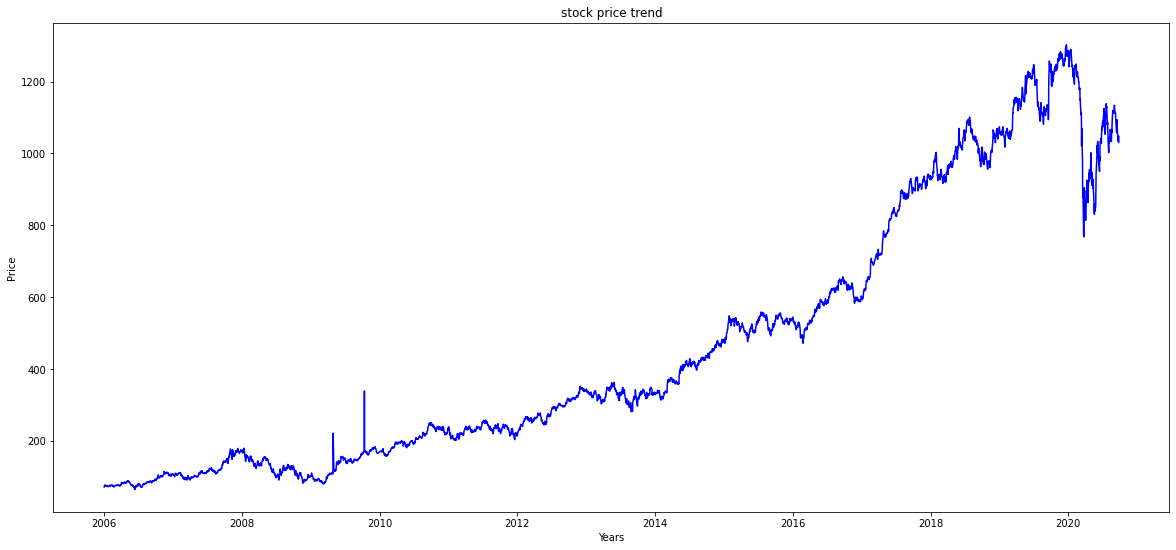

In [33]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime( 2006, 1, 2)
end = date.today()
stock = "HDFCBANK.NS"                            # "RELIANCE.NS","HINDUNILVR.NS","INFY.NS","^NSEI", "^BSESN", "TCS.NS"
data = web.DataReader( stock,"yahoo", start, end)
print(data)

import matplotlib.pyplot as plt

plt.figure(figsize=(20,9))
plt.title("stock price trend")
plt.xlabel("Years")
plt.ylabel("Price")
plt.plot(data['Close'], color= 'blue')
plt.show()

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = data['Adj Close'].values
df = df.reshape(-1, 1)

timestep = 50

dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-timestep:])

scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.fit_transform(dataset_test)

def create_dataset(dataset, timestep):
    x = []
    y = []
    for i in range(timestep, dataset.shape[0]):
        x.append(dataset[i-timestep:i, 0])
        y.append(dataset[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

x_train, y_train = create_dataset( dataset_train, timestep)
x_test, y_test = create_dataset( dataset_test, timestep)


# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [38]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

def model_lstm():
  model = Sequential()
  model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=96))
  model.add(Dense(units=1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')

  model.fit(x_train, y_train, epochs = 50, batch_size=8)
  model.save('stock_prediction.h5')
  
model_lstm()

Epoch 1/50
357/357 [==============================] - 31s 88ms/step - loss: 0.0020 - accuracy: 7.0200e-04
Epoch 2/50
357/357 [==============================] - 32s 90ms/step - loss: 4.4333e-04 - accuracy: 7.0200e-04
Epoch 3/50
357/357 [==============================] - 32s 89ms/step - loss: 4.5005e-04 - accuracy: 7.0200e-04
Epoch 4/50
357/357 [==============================] - 32s 89ms/step - loss: 4.5231e-04 - accuracy: 7.0200e-04
Epoch 5/50
357/357 [==============================] - 31s 87ms/step - loss: 3.4356e-04 - accuracy: 7.0200e-04
Epoch 6/50
357/357 [==============================] - 34s 96ms/step - loss: 4.4903e-04 - accuracy: 7.0200e-04
Epoch 7/50
357/357 [==============================] - 31s 88ms/step - loss: 3.0218e-04 - accuracy: 7.0200e-04
Epoch 8/50
357/357 [==============================] - 32s 90ms/step - loss: 3.0373e-04 - accuracy: 7.0200e-04
Epoch 9/50
357/357 [==============================] - 31s 88ms/step - loss: 2.4029e-04 - accuracy: 7.0200e-04
Epoch 10/50
35

In [39]:
model = load_model('stock_prediction.h5')
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [40]:
test_loss, test_acc = model.evaluate(x_test, y_test)

23/23 [==============================] - 1s 34ms/step - loss: 0.0021 - accuracy: 0.0028


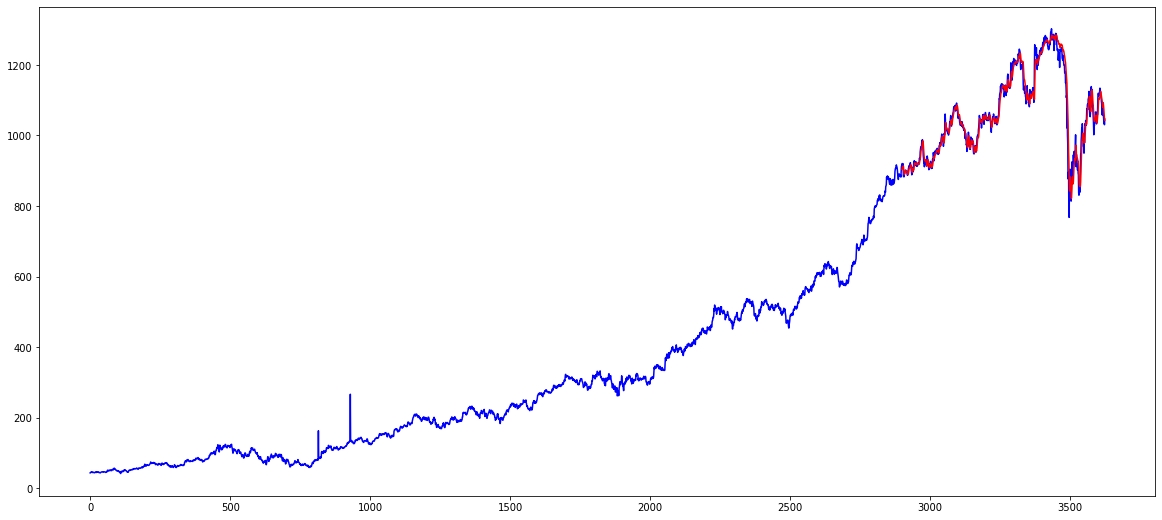

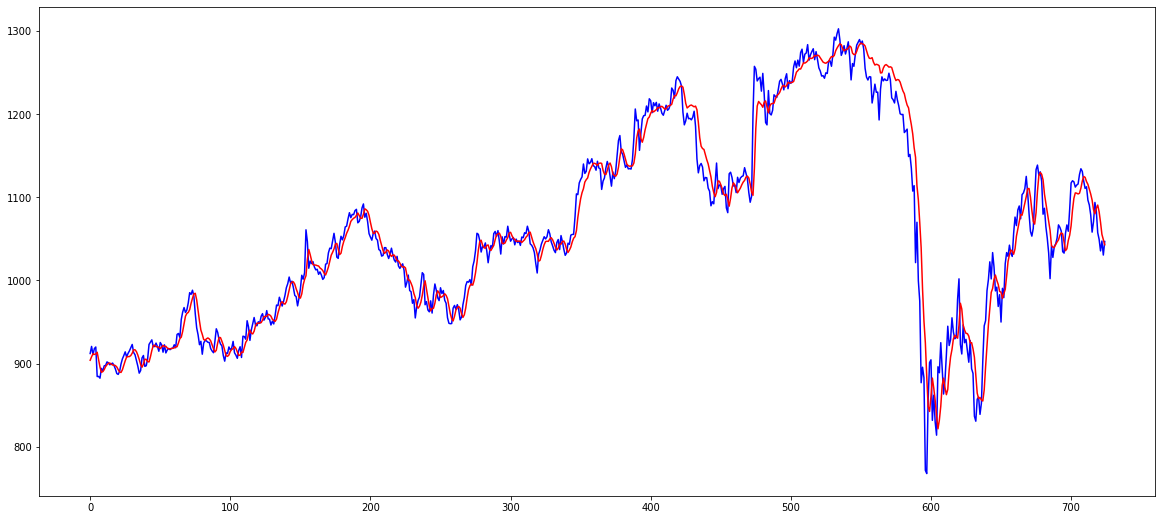

In [41]:
fig, ax = plt.subplots(figsize=(20,9))
plt.plot(df, color='blue')
ax. plot(range(len(y_train)+timestep, len(y_train)+timestep+len(predictions)), predictions, color='red')

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))
fig, ax = plt.subplots(figsize=(20,9))
ax.plot( y_test_scaled, color='blue')
plt.plot(predictions, color='red')